In [1]:
import numpy as np
import cv2
import os
from os import listdir
from os.path import isfile, isdir, join
from matplotlib import pyplot as plt
from PIL import Image

# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import tensorflow as tf
from RegModels import GreenUnet160, GreenUnet160b, GreenUnet320
from ImageProcessor import Merge, Split

### Training Phase

In [3]:
train_x = np.load('C:/Users/tmyda/Documents/UAV_reg/Splitted_training_data/NIR2G_160_train_x.npy')
train_y = np.load('C:/Users/tmyda/Documents/UAV_reg/Splitted_training_data/NIR2G_160_train_y.npy')

print('X.shape')
print(train_x.shape)
print('Y.shape')
print(train_y.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/tmyda/Documents/UAV_reg/Splitted_training_data/NIR2G_160_train_x.npy'

In [2]:
#model = GreenUnet160()
model = GreenUnet160b()
#model = GreenUnet320()
model.model().summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 160, 160, 32) 128         conv2d_1[0][0]                   
_______________________________________________________________________________________

In [4]:
opt = tf.keras.optimizers.Adam()
model.compile(loss='mse', optimizer=opt)
history = model.fit(train_x, train_y, batch_size=35, epochs=25, validation_split=0.2)


digraph Tile {
  n1 [label="I0\ninput_1\ Placeholder\ FLOAT32\(<tile\.Value\ SymbolicDim\ UINT64\(\)>,\ 160,\ 160,\ 1\)" shape=circle];
  n2 [label="I1\noutput_1_target\ Placeholder\ FLOAT32\(<tile\.Value\ SymbolicDim\ UINT64\(\)>,\ <tile\.Value\ SymbolicDim\ UINT64\(\)>,\ <tile\.Value\ SymbolicDim\ UINT64\(\)>,\ <tile\.Value\ SymbolicDim\ UINT64\(\)>\)" shape=circle];
  n3 [label="I2\noutput_1_sample_weights\ Placeholder\ FLOAT32\(<tile\.Value\ SymbolicDim\ UINT64\(\)>,\)" shape=circle];
  n4 [label="I3\nbatch_normalization_1/placeholder_1\ Placeholder\ BOOLEAN\(\)" shape=circle];
  n5 [label="O0\nMean\ FLOAT32\(\)" shape=doublecircle];
  n6 [label="batch_normalization_1/moving_mean\ Tensor\ FLOAT32\(32,\)" shape=circle];
  n7 [label="Add\ FLOAT32\(32,\)" shape=circle];
  n7 -> n6 [style=dotted];
  n8 [label="batch_normalization_1/moving_variance\ Tensor\ FLOAT32\(32,\)" shape=circle];
  n9 [label="Add\ FLOAT32\(32,\)" shape=circle];
  n9 -> n8 [style=dotted];
  n10 [label="batch_norm

  n2106 -> n2105 [label="L"];
  n928 -> n2105 [label="R"];
  n2105 -> n2104 [label="O"];
  n2107 [label="Mul" shape=oval];
  n928 -> n2107 [label="L"];
  n144 -> n2107 [label="R"];
  n2107 -> n2101 [label="O"];
  n2108 [label="Sub" shape=oval];
  n142 -> n2108 [label="L"];
  n2109 [label="TrueDiv" shape=box];
  n2109 -> n2108 [label="R"];
  n2108 -> n143 [label="O"];
  n2110 [label="TrueDiv" shape=oval];
  n2111 [label="Mul" shape=box];
  n2111 -> n2110 [label="L"];
  n2112 [label="Add" shape=box];
  n2112 -> n2110 [label="R"];
  n2110 -> n2109 [label="O"];
  n2113 [label="Add" shape=oval];
  n2114 [label="Sqrt" shape=box];
  n2114 -> n2113 [label="L"];
  n2115 [label="<unnamed>\ Real" shape=box];
  n2115 -> n2113 [label="R"];
  n2113 -> n2112 [label="O"];
  n2116 [label="Sqrt" shape=oval];
  n141 -> n2116 [label="I"];
  n2116 -> n2114 [label="O"];
  n2117 [label="Mul" shape=oval];
  n917 -> n2117 [label="L"];
  n139 -> n2117 [label="R"];
  n2117 -> n2111 [label="O"];
  n2118 [label="A

Unknown: Binding missing placeholder

In [5]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Total Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

NameError: name 'history' is not defined

#### Save weights

In [7]:
model.save_weights('./weights/GreenUnet160b_weights_202017Nov.h5')

### Trained Models

In [4]:
model.load_weights('./weights/GreenUnet160_weights_202015Nov.h5')

(160, 160)


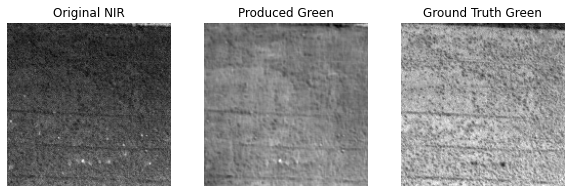

In [9]:
index = 1095
img = train_x[index:index+1, :, :, :]
img_g = train_y[index, :, :, 0]
p = model.predict(img)
p = p.squeeze()
img = img.squeeze()
print(p.shape)

img_ls = [img, p, img_g]
title = ['Original NIR', 'Produced Green', 'Ground Truth Green']
fig = plt.figure(figsize=(10,3))
for i in range(3):
    ax = fig.add_subplot(i+131)
    ax.set_title(title[i])
    ax.axis('off')
    ax.imshow(img_ls[i], cmap='gray')

### Predict Tiles & Merge 

(1280, 960)


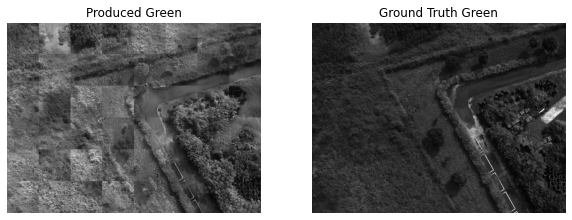

In [84]:
size = 160
index = int(960/size * 1280/size)
name = '0079'
NIR = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_4.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
green = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_2.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)

NIR = NIR/255
NIR_set = Split(NIR)
NIR_set = np.stack(NIR_set, axis=0)
NIR_set = np.expand_dims(NIR_set, axis=-1)
p = Merge(NIR_set, model.predict)
print(p.size)

img_ls = [p, green]
title = ['Produced Green', 'Ground Truth Green']
fig = plt.figure(figsize=(10,6))
for i in range(2):
    ax = fig.add_subplot(i+121)
    ax.set_title(title[i])
    ax.axis('off')
    ax.imshow(img_ls[i], cmap='gray')
    
p.save('./outputs/produced_green.tif')

### Register

In [86]:
from SIFT_and_RANSAC import SIFT, matcher, getHomography

img1 = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_2.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_4.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
dummy = cv2.imread('./outputs/produced_green.tif', cv2.IMREAD_GRAYSCALE)

kp1, des1 = SIFT(img1)
kp2, des2 = SIFT(img2)
matches = matcher(des1, des2)
h = getHomography(matches, kp1, kp2)
print(h)

img = np.zeros((img1.shape[0], img1.shape[1], 3), dtype='uint8')
height, width, channels = img.shape

img[:, :, 0] = img1
img[:, :, 1] = 0 #cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_3toIMG_{name}_2_registered.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
img[:, :, 2] = cv2.warpAffine(img2, h, (width, height))
cv2.imshow('Reg', img)
cv2.imwrite('./outputs/{}_Reg.tif'.format(name), img)

cv2.waitKey(0)
cv2.destroyAllWindows()

[[ 9.93845785e-01  2.55003515e-04  3.34201103e+01]
 [-2.55003515e-04  9.93845785e-01 -3.45442408e+01]]
